In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
plt.rcParams["figure.figsize"] = (10,10)

In [2]:
path = "data/images/d_3.png"

In [3]:
def to_RGB(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [4]:
def get_edges(img_gray):
    CANNY_THRESHOLD1 = 100
    CANNY_THRESHOLD2 = 200
    return cv2.Canny(img_gray, CANNY_THRESHOLD1, CANNY_THRESHOLD2)

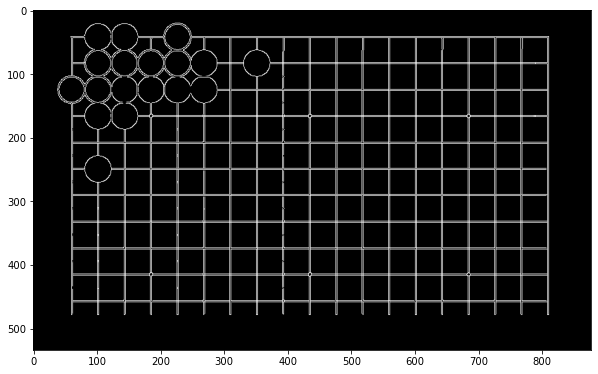

In [5]:
img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
edges = get_edges(img_gray)
plt.imshow(to_RGB(edges))
plt.show() 

In [6]:
def all_lines(img_gray):
    CANNY_THRESHOLD1 = 100
    CANNY_THRESHOLD2 = 200
    HOUGH_RHO = 1
    HOUGH_THETA = np.pi/180
    HOUGH_THRESHOLD = 100
    edges = cv2.Canny(img_gray, CANNY_THRESHOLD1, CANNY_THRESHOLD2)
    size = min(img_gray.shape[0:2]) 
    lines = cv2.HoughLinesP(edges, rho=HOUGH_RHO, theta=HOUGH_THETA, threshold=HOUGH_THRESHOLD,
                            minLineLength=size/2, maxLineGap=size)
    return np.reshape(lines, (lines.shape[0], lines.shape[2]))

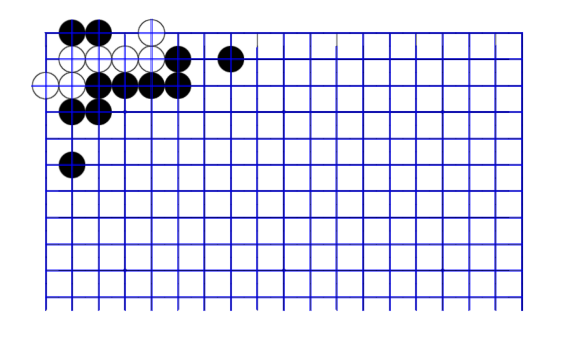

In [7]:
img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
lines = all_lines(img_gray)
img = cv2.imread(path, cv2.IMREAD_COLOR)
for line in lines:
    x1, y1, x2, y2 = line
    cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 1)
plt.imshow(to_RGB(img))
plt.axis('off')
plt.show() 

In [8]:
def lines_recognition(img_gray):
    
    CANNY_THRESHOLD1 = 100
    CANNY_THRESHOLD2 = 200
    HOUGH_RHO = 1
    HOUGH_THETA = np.pi/180
    HOUGH_THRESHOLD = 100
    VERTICAL_TAN_MIN = 50
    HORIZONTAL_TAN_MAX = 0.02
    
    # Find all lines
    edges = cv2.Canny(img_gray, CANNY_THRESHOLD1, CANNY_THRESHOLD2)
    size = min(img_gray.shape[0:2]) 
    lines = cv2.HoughLinesP(edges, rho=HOUGH_RHO, theta=HOUGH_THETA, threshold=HOUGH_THRESHOLD,
                            minLineLength=size/2, maxLineGap=size/2)
    lines = np.reshape(lines, (lines.shape[0], lines.shape[2]))
    # Divide the lines into vertical and horizontal
    v_lines = []
    h_lines = []
    for line in lines:
        x1, y1, x2, y2 = line
        if (x1 == x2):
            v_lines.append(line)
        else:
            slope = (y2 - y1)/(x2 - x1)
            if (abs(slope) > VERTICAL_TAN_MIN):
                v_lines.append(line)
            elif (abs(slope) < HORIZONTAL_TAN_MAX):
                h_lines.append(line)
    v_lines = np.array(v_lines)
    h_lines = np.array(h_lines)
    # Merge close lines
    return merge_lines(v_lines, True), merge_lines(h_lines, False)

In [9]:
def merge_lines(lines, is_vertical):
    
    # ???
    MIN_DIST = 10
    
    close_groups = []
    grouped = set() 
    for i in range(lines.shape[0]):
        if i in grouped:
            continue
        close_groups.append([i])
        grouped.add(i)
        for j in set(range(i + 1, lines.shape[0])) - grouped:
            x1_i, y1_i, x2_i, y2_i = lines[i]
            x1_j, y1_j, x2_j, y2_j = lines[j]
            if is_vertical:
                dist = min(abs(x1_i - x1_j), abs(x2_i - x2_j))
            else:
                dist = min(abs(y1_i - y1_j), abs(y2_i - y2_j))
            if (dist <= MIN_DIST):
                close_groups[-1].append(j)
                grouped.add(j)
    merged_lines = []
    for group in close_groups:
        line_group = lines[group]
        # possible bag
        if is_vertical:
            x = round(np.mean(line_group[:, [0, 2]]))
            merged_line = [x, np.amax(line_group[:, 1]), x, np.amin(line_group[:, 3])]
        else:
            y = round(np.mean(line_group[:, [1, 3]]))
            merged_line = [np.amin(line_group[:, 0]), y, np.max(line_group[:, 2]), y]
        merged_lines.append(merged_line)
    return np.array(merged_lines)

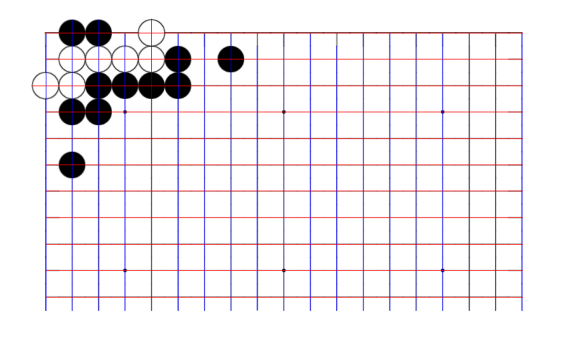

In [10]:
img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
v_lines, h_lines = lines_recognition(img_gray)
img = cv2.imread(path, cv2.IMREAD_COLOR)
for line in v_lines:
    x1, y1, x2, y2 = line
    cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 1)
for line in h_lines:
    x1, y1, x2, y2 = line
    cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 1)
plt.imshow(to_RGB(img))
plt.axis('off')
plt.show() 

In [11]:
def get_cell_size(v_lines, h_lines):
    return round(np.mean([round(np.ptp(v_lines[:, 0]) / v_lines.shape[0] - 1),
                          round(np.ptp(h_lines[:, 1]) / h_lines.shape[0] - 1)]))

In [12]:
def find_intersections(v_lines, h_lines):
    return np.array(np.meshgrid(v_lines[:, 0], h_lines[:, 1])).T.reshape(-1, 2)

In [13]:
intersections = find_intersections(v_lines, h_lines)

In [14]:
cell_size = get_cell_size(v_lines, h_lines)
cell_size

38

In [15]:
def find_circles(img_gray, cell_size, intersections):
    METHOD = cv2.HOUGH_GRADIENT
    DP = 2
    PARAM1 = 200
    PARAM2 = 20
    MIN_DIST_COEFF = 0.9
    MAX_R_COEFF = 0.6
    MIN_R_COEFF = 0.4
    
    return cv2.HoughCircles(img_gray, method=METHOD, dp=DP,
                               minDist=round(cell_size * MIN_DIST_COEFF),
                               param1=PARAM1, param2=PARAM2, minRadius=round(cell_size * MIN_R_COEFF),
                               maxRadius=round(cell_size * MAX_R_COEFF))[0, :]

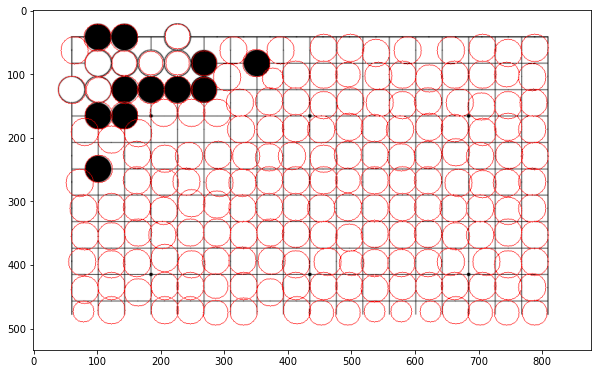

In [16]:
img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
circles = find_circles(img_gray, cell_size, intersections)

img = cv2.imread(path, cv2.IMREAD_COLOR)
for circle in circles:
    cv2.circle(img ,(circle[0],circle[1]), round(circle[2]),(0,0,255),1)

plt.imshow(to_RGB(img))
plt.show()

In [17]:
def stones_recognition(img_gray, cell_size, intersections):
    METHOD = cv2.HOUGH_GRADIENT
    DP = 2
    PARAM1 = 200
    PARAM2 = 20
    MIN_DIST_COEFF = 0.9
    MAX_R_COEFF = 0.6
    MIN_R_COEFF = 0.4
    MIN_INTERSECTION_DIST_COEFF = 0.2
    
    circles = cv2.HoughCircles(img_gray, method=METHOD, dp=DP,
                               minDist=round(cell_size * MIN_DIST_COEFF),
                               param1=PARAM1, param2=PARAM2, minRadius=round(cell_size * MIN_R_COEFF),
                               maxRadius=round(cell_size * MAX_R_COEFF))[0, :]
    # Filter circles
    stones = []
    radii = []
    for circle in circles:
        in_intersection = False
        for intersection in intersections:
            if (np.linalg.norm(circle[:2] - intersection) <= MIN_INTERSECTION_DIST_COEFF * cell_size):
                in_intersection = True
                break
        if in_intersection:
            stones.append(intersection)
            radii.append(circle[2])
    return stones, round(np.mean(radii))

In [18]:
def colorize(img_gray, stones, radius):
    WHITE_THRESHOLD = 255/2
    white_stones = []
    black_stones = []
    for stone in stones:
        average_color = np.mean(img_gray[stone[1] - radius//2 : stone[1] + radius//2,
                                         stone[0] - radius//2 : stone[0] + radius//2])
        if average_color > WHITE_THRESHOLD:
            white_stones.append(stone)
        else:
            black_stones.append(stone)
    return white_stones, black_stones

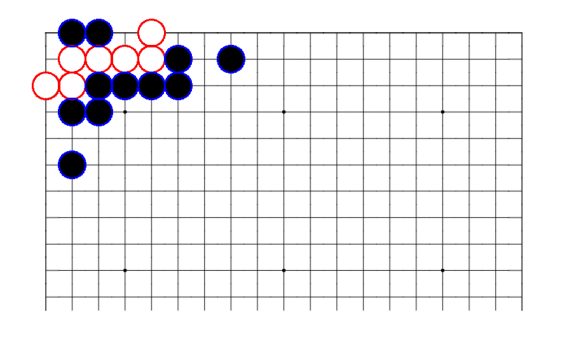

In [19]:
img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
stones, radius = stones_recognition(img_gray, cell_size, intersections)
white_stones, black_stones = colorize(img_gray, stones, radius)

img = cv2.imread(path, cv2.IMREAD_COLOR)
for stone in white_stones:
    cv2.circle(img ,(stone[0],stone[1]), radius,(0,0,255),2)
for stone in black_stones:
    cv2.circle(img ,(stone[0],stone[1]), radius,(255,0,0),2)

plt.imshow(to_RGB(img))
plt.axis('off')
plt.show()

In [20]:
def visualize(img):
    try:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        v_lines, h_lines = lines_recognition(img_gray)
        intersections = find_intersections(v_lines, h_lines)
        cell_size = get_cell_size(v_lines, h_lines)
        stones, radius = stones_recognition(img_gray, cell_size, intersections)
        white_stones, black_stones = colorize(img_gray, stones, radius)
        for intersection in intersections:
            cv2.circle(img, (intersection[0], intersection[1]), 5, (255,0,255), -1)
        for stone in white_stones:
            cv2.circle(img ,(stone[0],stone[1]), radius,(0,0,255),3)
        for stone in black_stones:
            cv2.circle(img ,(stone[0],stone[1]), radius,(255,0,0),3)
        plt.imshow(to_RGB(img))
        plt.show()
    except:
        pass

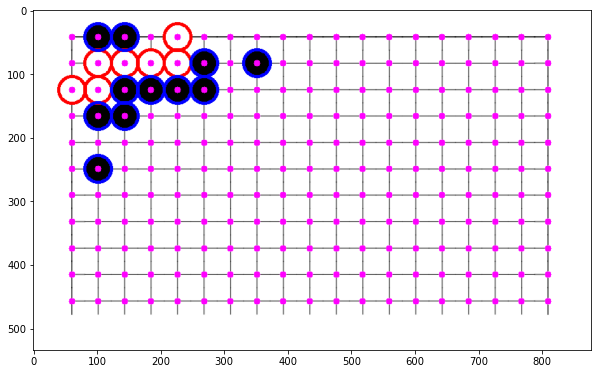

In [21]:
img = cv2.imread(path, cv2.IMREAD_COLOR)
visualize(img)

data/images/d_1.png


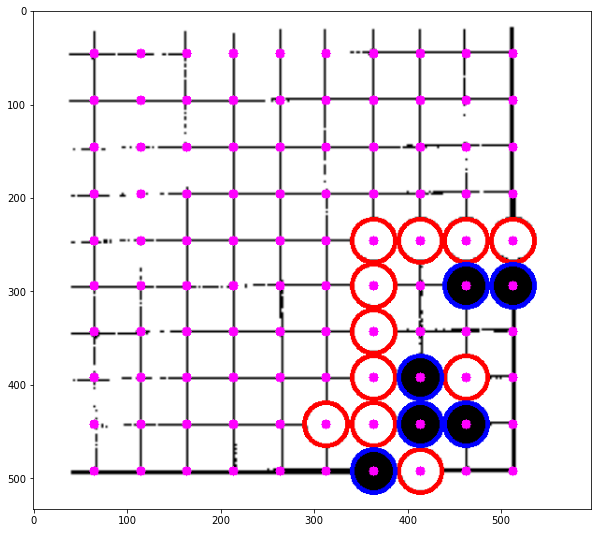

data/images/d_2.png


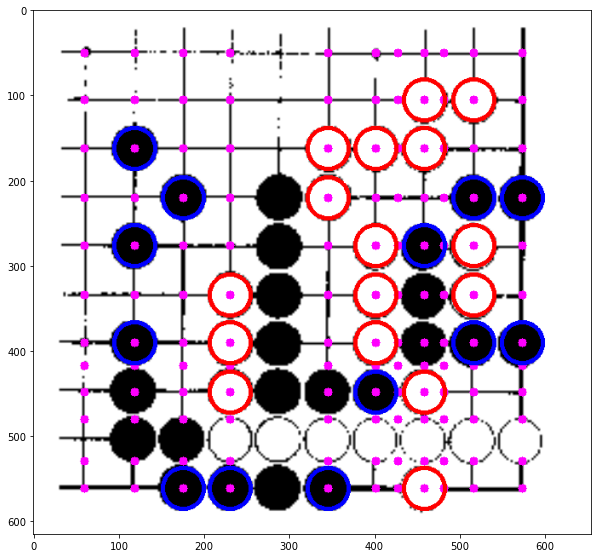

data/images/d_3.png


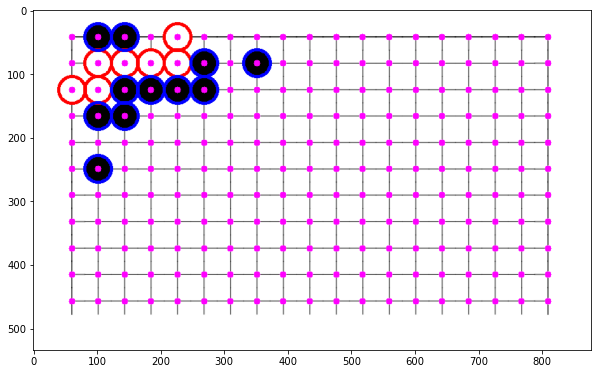

data/images/d_7.png


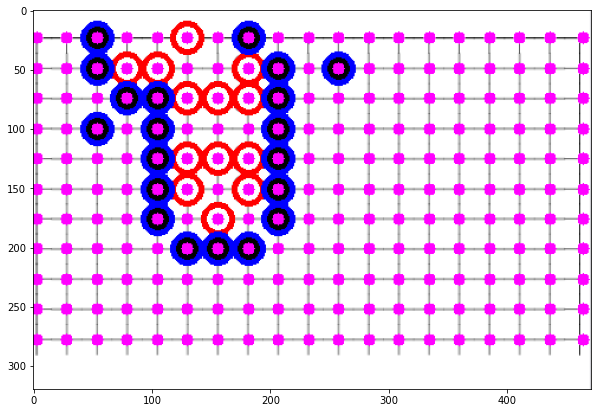

data/images/d_6.png
data/images/d_4.png
data/images/d_5.png


/Users/eugene/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/eugene/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


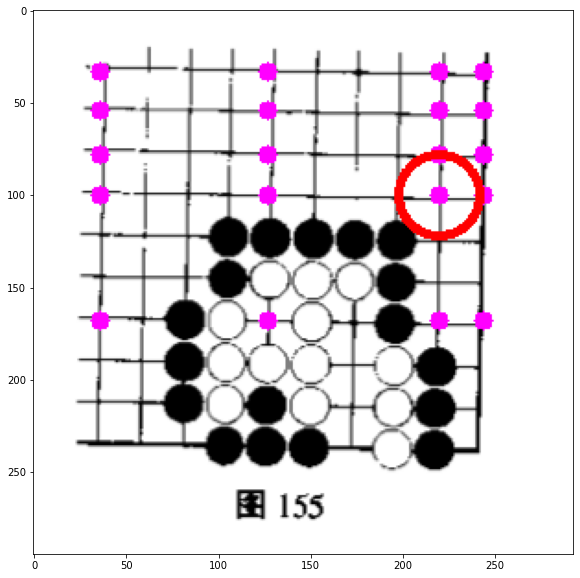

data/images/d_8.png


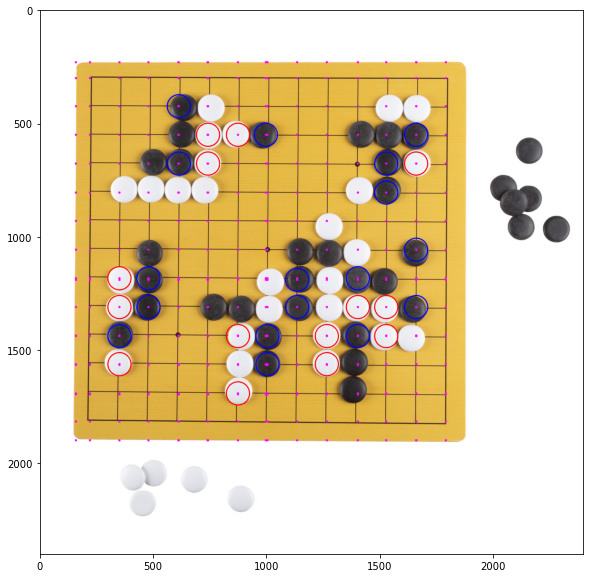

In [22]:
img_files = glob.glob('data/images/d_*')
for img_file in img_files:
    print(img_file)
    img = cv2.imread(img_file)
    visualize(img)